In [35]:
library(tidyverse)
theme_set(theme_minimal(base_size = 14))

df <- read_csv("/Users/snehavyas7/Downloads/social_media_ad_optimization.csv")

df <- df %>%
  mutate(conversion = as.integer(conversion))

head(df)

Rows: 500 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): user_id, gender, location, interests, ad_id, ad_category, ad_platf...
dbl  (6): age, impressions, clicks, conversion, time_spent_on_ad, engagement...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


user_id,age,gender,location,interests,ad_id,ad_category,ad_platform,ad_type,impressions,clicks,conversion,time_spent_on_ad,day_of_week,device_type,engagement_score
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>,<dbl>
U0001,58,M,USA,Food,A0001,Sportswear,Facebook,Image,3,0,0,3.38,Friday,Mobile,0.02
U0002,55,F,USA,Tech,A0002,Electronics,Facebook,Image,9,9,1,6.77,Saturday,Tablet,0.93
U0003,52,F,UK,Gaming,A0003,Luggage,Instagram,Image,13,12,1,13.26,Wednesday,Mobile,0.93
U0004,31,F,USA,Tech,A0004,Gadgets,Facebook,Video,14,5,0,24.41,Saturday,Desktop,0.28
U0005,52,M,India,Tech,A0005,Luggage,Instagram,Carousel,10,5,0,21.43,Monday,Tablet,0.35
U0006,32,F,USA,Fashion,A0006,Electronics,Instagram,Video,8,5,1,11.30,Saturday,Desktop,0.77


In [36]:
df <- df %>%
  mutate(
    segment = paste(age, gender, interests, location, sep = "_")
  )

df %>%
  select(age, gender, interests, location, segment) %>%
  head()

age,gender,interests,location,segment
<dbl>,<chr>,<chr>,<chr>,<chr>
58,M,Food,USA,58_M_Food_USA
55,F,Tech,USA,55_F_Tech_USA
52,F,Gaming,UK,52_F_Gaming_UK
31,F,Tech,USA,31_F_Tech_USA
52,M,Tech,India,52_M_Tech_India
32,F,Fashion,USA,32_F_Fashion_USA


In [37]:
segment_perf <- df %>%
  group_by(segment) %>%
  summarise(
    impressions_sum = sum(impressions, na.rm = TRUE),
    conversions_sum = sum(conversion, na.rm = TRUE),
    conversion_rate = mean(conversion, na.rm = TRUE),
    n_rows = n()
  ) %>%
  ungroup()

cat("Number of unique segments:", nrow(segment_perf), "\n")

head(segment_perf)

Number of unique segments: 477 


segment,impressions_sum,conversions_sum,conversion_rate,n_rows
<chr>,<dbl>,<int>,<dbl>,<int>
18_F_Fashion_Canada,13,0,0,1
18_M_Fashion_Australia,12,0,0,1
18_M_Travel_UK,3,0,0,1
18_Other_Gaming_India,13,0,0,1
18_Other_Tech_Germany,11,0,0,1
19_F_Fashion_USA,11,0,0,1


In [38]:
 imp_thresh <- quantile(segment_perf$impressions_sum, 0.75, na.rm = TRUE)
conv_thresh <- quantile(segment_perf$conversions_sum, 0.25, na.rm = TRUE)

cat("High-impressions threshold:", imp_thresh, "\n")
cat("Low-conversions threshold:", conv_thresh, "\n")

High-impressions threshold: 12 
Low-conversions threshold: 0 


In [39]:
underperforming_segments <- segment_perf %>%
  filter(
    impressions_sum >= imp_thresh,
    conversions_sum <= conv_thresh
  ) %>%
  arrange(
    desc(impressions_sum),   
    conversion_rate          
  )

cat("Underperforming full audience segments:\n")
head(underperforming_segments, 20)

Underperforming full audience segments:


segment,impressions_sum,conversions_sum,conversion_rate,n_rows
<chr>,<dbl>,<int>,<dbl>,<int>
19_Other_Tech_USA,15,0,0,1
22_F_Tech_Australia,15,0,0,1
22_Other_Food_USA,15,0,0,1
25_F_Food_India,15,0,0,1
26_F_Food_USA,15,0,0,1
27_F_Fashion_USA,15,0,0,1
32_Other_Fitness_India,15,0,0,1
33_M_Fitness_Canada,15,0,0,1
41_M_Fashion_Australia,15,0,0,1


In [40]:
under_df <- underperforming_segments
head(under_df)

segment,impressions_sum,conversions_sum,conversion_rate,n_rows
<chr>,<dbl>,<int>,<dbl>,<int>
19_Other_Tech_USA,15,0,0,1
22_F_Tech_Australia,15,0,0,1
22_Other_Food_USA,15,0,0,1
25_F_Food_India,15,0,0,1
26_F_Food_USA,15,0,0,1
27_F_Fashion_USA,15,0,0,1


In [41]:
bad_segments <- unique(underperforming_segments$segment)

under_df <- df %>%
  filter(segment %in% bad_segments)

under_df <- under_df %>%
  mutate(
    age_group = cut(
      age,
      breaks = seq(0, 70, by = 10),     
      right = FALSE,
      labels = paste0(seq(0, 60, by = 10), "-", seq(9, 69, by = 10))
    ))

In [42]:
agegroup_counts <- under_df %>%
  count(age_group) %>%         
  arrange(age_group)          

agegroup_counts

age_group,n
<fct>,<int>
10-19,5
20-29,16
30-39,14
40-49,21
50-59,17
60-69,2


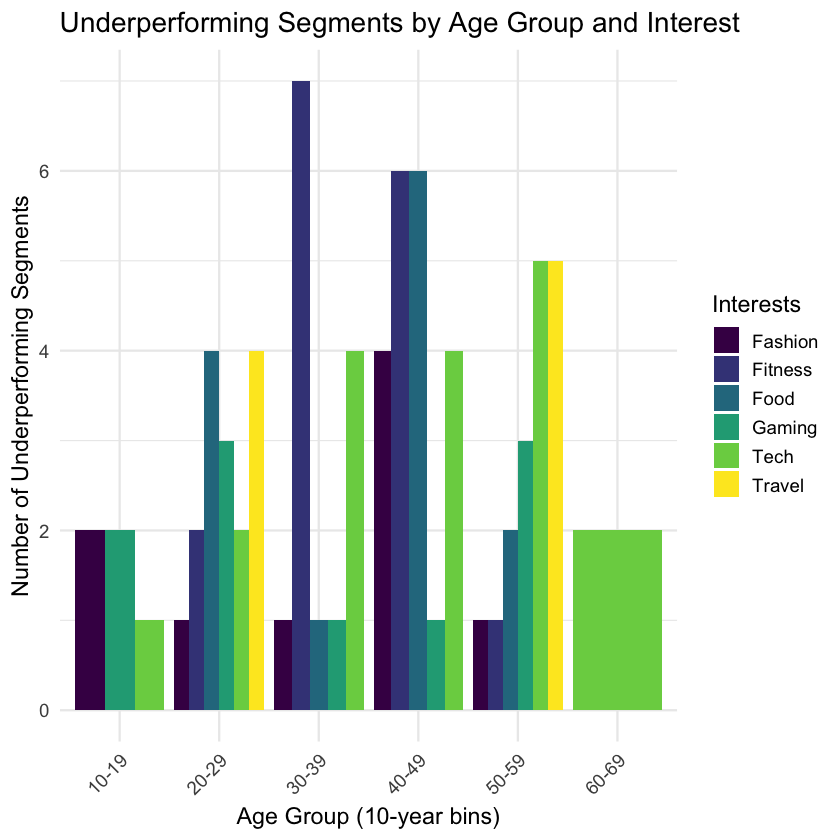

In [43]:
library(ggplot2)

ggplot(under_df, aes(x = age_group, fill = interests)) +
  geom_bar(position = "dodge") +
  scale_fill_viridis_d() +   
  labs(
    title = "Underperforming Segments by Age Group and Interest",
    x = "Age Group (10-year bins)",
    y = "Number of Underperforming Segments",
    fill = "Interests"
  ) +
  theme_minimal(base_size = 14) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1)
  )

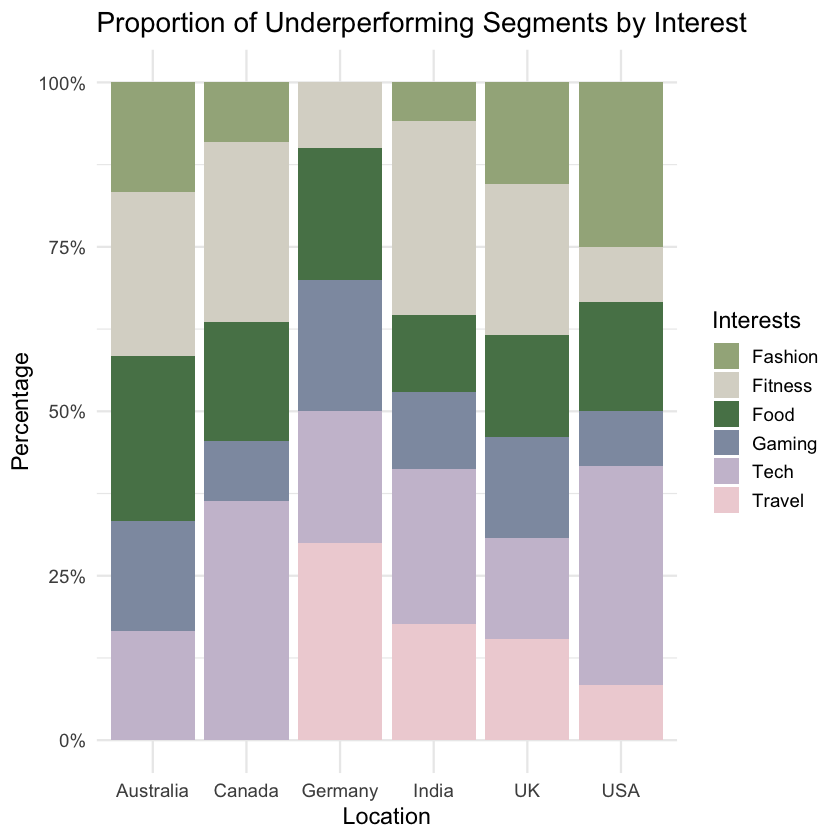

In [44]:
ggplot(under_df, aes(x = location, fill = interests)) +
  geom_bar(position = "fill") +
  scale_fill_manual(values = c(
    "#A3B18A",
    "#DAD7CD",
    "#588157",
    "#8E9AAF",
    "#CBC0D3",
    "#EFD3D7"
  )) +
  scale_y_continuous(labels = scales::percent) +
  labs(
    title = "Proportion of Underperforming Segments by Interest",
    x = "Location",
    y = "Percentage",
    fill = "Interests"
  ) +
  theme_minimal(base_size = 14)